**Copyright 2018 The TensorFlow Authors.**

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Image classification**

This tutorial shows how to classify images of flowers using a tf.keras.Sequential model and load data using tf.keras.utils.image_dataset_from_directory. It demonstrates the following concepts:

1. Efficiently loading a dataset off disk.
2. Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.


This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process.

In addition, the notebook demonstrates how to convert a saved model to a TensorFlow Lite model for on-device machine learning on mobile, embedded, and IoT devices.

**Setup**

Import TensorFlow and other necessary libraries:

In [3]:
# Load libraries:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Download and explore the dataset:**

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

flower_photo/

  daisy/

  dandelion/

  roses/

  sunflowers/
  
  tulips/

**DWONLAOD DATA TO PC:**

In [4]:
# # DWONLAOD DATA TO PC:

# import requests
# import tarfile
# import os

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# download_path = './flower_data.tgz'
# extract_path = './flower_photos'

# # Download the file
# print(f"Downloading data from {dataset_url}...")
# response = requests.get(dataset_url, stream=True)
# response.raise_for_status() # Raise an exception for bad status codes
# with open(download_path, 'wb') as f:
#     for chunk in response.iter_content(chunk_size=8192):
#         f.write(chunk)
# print(f"Download complete. File saved to {download_path}")

# # Extract the file
# print(f"Extracting data to {extract_path}...")
# with tarfile.open(download_path, 'r:gz') as tar:
#     tar.extractall(path='./') # Extract to the current directory
# print("Extraction complete.")

# # Verify the extracted directory
# if os.path.exists(extract_path):
#     print(f"Data extracted successfully to {extract_path}")
#     # You can now use this path to load your data for further processing
# else:
#     print(f"Error: Extraction path {extract_path} not found.")

In [5]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
# Corrected: data_dir now points directly to the extracted directory
# data_dir = pathlib.Path(data_dir).with_suffix('') # Removed this line

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [6]:
# Using the corrected data_dir from the previous cell
# Corrected: Search for images within the 'flower_photos' subdirectory
image_count = len(list(pathlib.Path(data_dir).glob('flower_photos/*/*.jpg')))
print(image_count)

3670



Here are some roses:

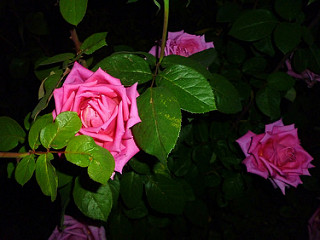

In [7]:
# Convert data_dir to a Path object and glob for roses within flower_photos
roses = list(pathlib.Path(data_dir).glob('flower_photos/roses/*'))
PIL.Image.open(str(roses[10]))

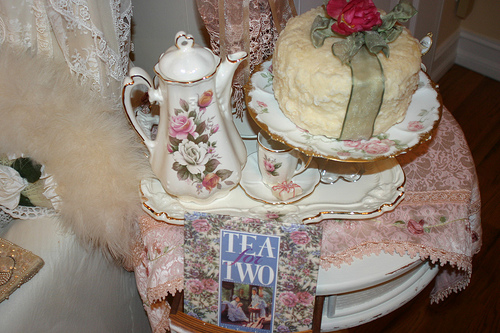

In [8]:
PIL.Image.open(str(roses[1]))

and some tulips:


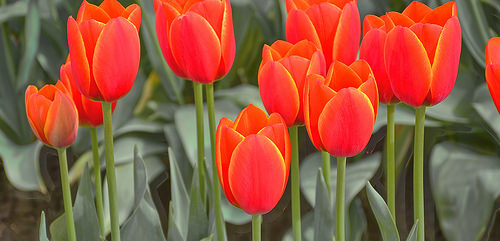

In [9]:
tulips = list(pathlib.Path(data_dir).glob('flower_photos/tulips/*'))
PIL.Image.open(str(tulips[0]))

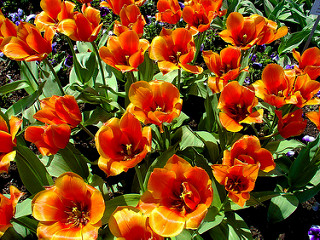

In [10]:
PIL.Image.open(str(tulips[12]))

**Load data using a Keras utility**

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the Load and preprocess images tutorial.

**Create a dataset:**

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_widht = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [14]:
import os

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'flower_photos'), # Point to the flower_photos subdirectory
    validation_split = 0.2,
    subset = "training",
    seed=123,
    image_size = (img_height, img_widht),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
import os

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'flower_photos'), # Point to the flower_photos subdirectory
    validation_split = 0.2,
    subset = "validation",
    seed=123,
    image_size = (img_height, img_widht),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.



You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**Visualize the data**

Here are the first nine images from the training dataset:

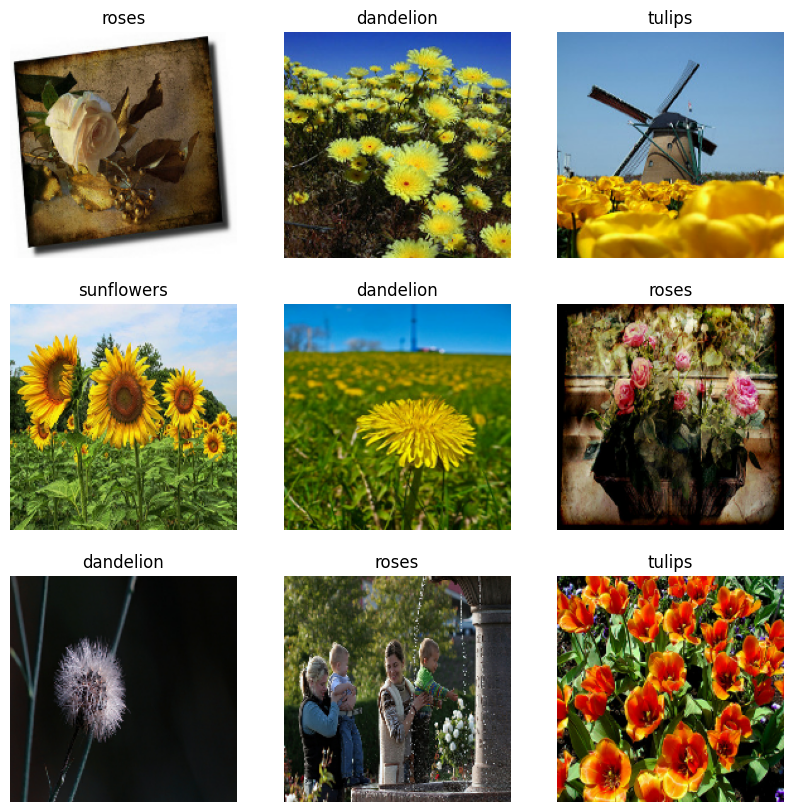

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras Model.fit method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [18]:
for images_batch, labels_batch in train_ds:
  print(images_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Configure the dataset for performance:**

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

1. Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
2. Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # cache() keeps images in memory after they're loaded off disk during the first epoch
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # prefetch() overlaps data preprocessing and model execution while training

**Standardize the data:**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [20]:
normalization_layer = layers.Rescaling(1./255)   # rescale pixel values from [0, 255] to [0, 1]

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0



Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the image_size argument of tf.keras.utils.image_dataset_from_directory. If you want to include the resizing logic in your model as well, you can use the tf.keras.layers.Resizing layer.

**A basic Keras model**

Create the model:

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_widht, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile the model**

For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model summary**

View all the layers of the network using the Keras Model.summary method:

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

**Train the model:**

Train the model for 10 epochs with the Keras Model.fit method:

In [25]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.2359 - loss: 1.8652 - val_accuracy: 0.4864 - val_loss: 1.2795
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5357 - loss: 1.1351 - val_accuracy: 0.5804 - val_loss: 1.0228
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 989ms/step - accuracy: 0.6712 - loss: 0.8638 - val_accuracy: 0.6689 - val_loss: 0.9031
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 971ms/step - accuracy: 0.7604 - loss: 0.6319 - val_accuracy: 0.6594 - val_loss: 0.9336
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8615 - loss: 0.4021 - val_accuracy: 0.6403 - val_loss: 1.0698
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 992ms/step - accuracy: 0.9280 - loss: 0.2350 - val_accuracy: 0.6608 - val_loss: 1.1748
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9625 - loss: 0.1211 - val_accuracy: 0.6144 - val_loss: 1.3653
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9702 - loss: 0.0970 - val_accuracy: 0.6662

In [26]:

# print the final training and validation accuracy + loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# print the final training and validation accuracy + loss
print(f"----{'-'*10}----")
print("Training accuracy: {:.2f}".format(acc[-1]))
print("Validation accuracy: {:.2f}".format(val_acc[-1]))
print(f"----{'-'*10}----")
print("Training loss: {:.2f}".format(loss[-1]))
print("Validation loss: {:.2f}".format(val_loss[-1]))

------------------
Training accuracy: 0.99
Validation accuracy: 0.66
------------------
Training loss: 0.04
Validation loss: 1.72


**Visualize training results**

Create plots of the loss and accuracy on the training and validation sets:

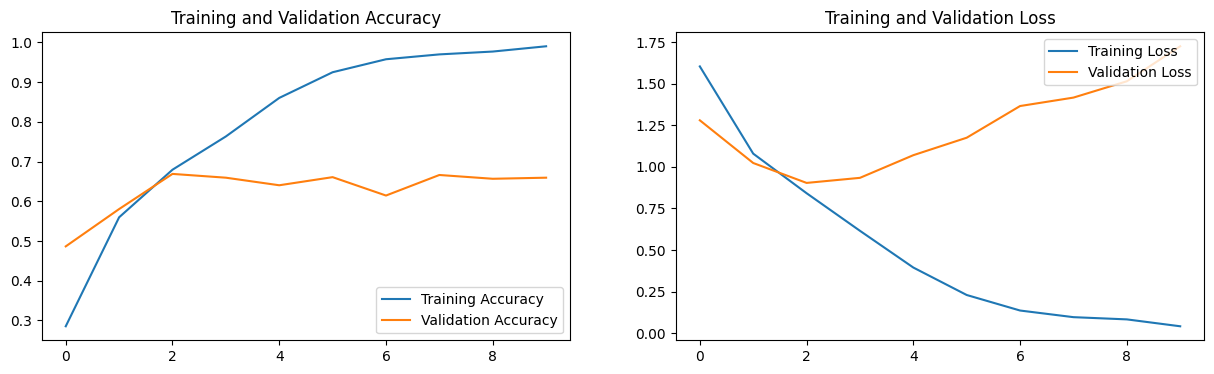

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that your model is performing very well on the training data, with accuracy increasing and loss decreasing. However, the validation accuracy seems to level off, and the validation loss starts to increase after a few epochs. This is a classic sign of overfitting. Your model is learning the training data too well, including the noise, and is not generalizing well to unseen data (the validation set).

Yes, the model needs improvement to address this overfitting.

The next steps should focus on techniques to reduce overfitting:

Data Augmentation: Introduce random transformations to your training images (like rotation, zooming, flipping) to create more diverse training data. This helps the model see a wider variety of images and become less sensitive to specific variations in the training set.
Dropout: Add Dropout layers to your model. Dropout randomly sets a fraction of the input units to 0 at each training step. This helps prevent neurons from co-adapting and makes the model more robust.

**Overfitting:**


In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.


**Data augmentation:**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # Removed input_shape
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)


Visualize a few augmented examples by applying data augmentation to the same image several times:

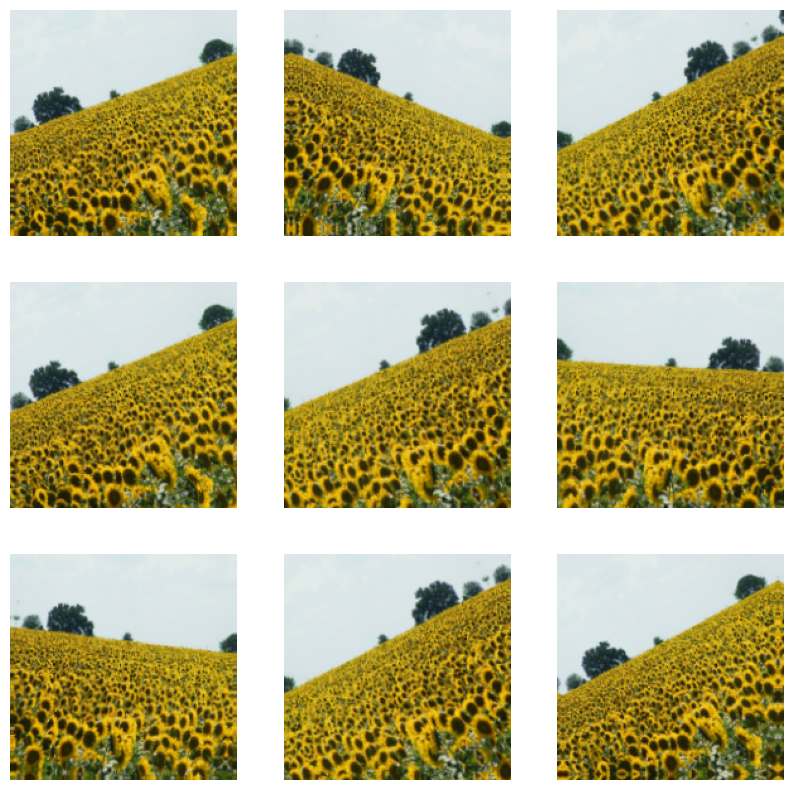

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

**Dropout:**

Another technique to reduce overfitting is to introduce dropout{:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

**Compile and train the model**

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 180, 180, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 90, 90, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 90, 90, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 45, 45, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 45, 45, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 30976)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (32, 5)                │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
%%time
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=0
)

CPU times: user 44min 14s, sys: 2min 36s, total: 46min 51s
Wall time: 28min 21s


**Visualize training results:**

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

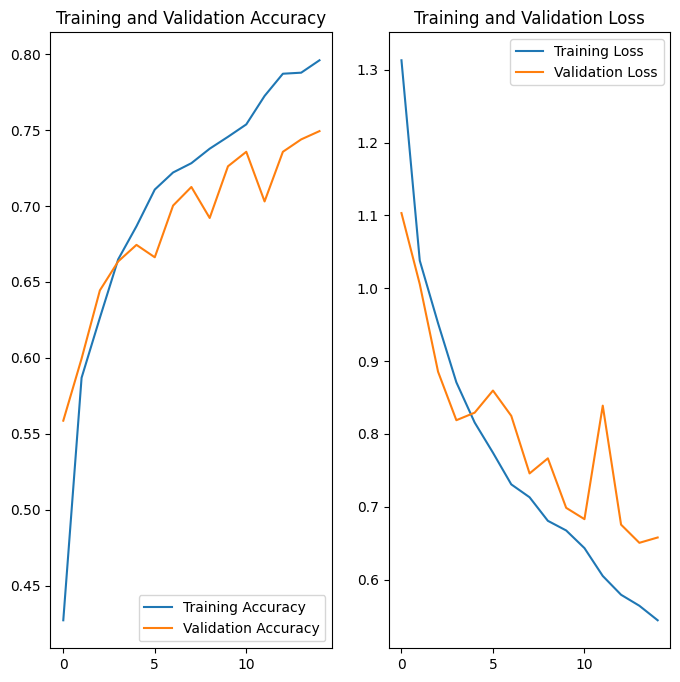

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# print the final training and validation accuracy + loss
print(f"----{'-'*10}----")
print("Training accuracy: {:.2f}".format(acc[-1]))
print("Validation accuracy: {:.2f}".format(val_acc[-1]))
print(f"----{'-'*10}----")
print("Training loss: {:.2f}".format(loss[-1]))
print("Validation loss: {:.2f}".format(val_loss[-1]))

------------------
Training accuracy: 0.80
Validation accuracy: 0.75
------------------
Training loss: 0.54
Validation loss: 0.66


**Predict on new data:**

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [37]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_widht)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
This image most likely belongs to sunflowers with a 91.92 percent confidence.


**Use TensorFlow Lite**

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

**Convert the Keras Sequential model to a TensorFlow Lite model:**

To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

In this example, take the trained Keras Sequential model and use tf.lite.TFLiteConverter.from_keras_model to generate a TensorFlow Lite model:

In [38]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpppzt7eo8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(32, 180, 180, 3), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(32, 5), dtype=tf.float32, name=None)
Captures:
  138298539443600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380622288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380623440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380624784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380620176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380620368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380626128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380622480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380621136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138298380625360: TensorSpec(shape=(), dtype=tf.resource, name=None)


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about TensorFlow Lite signatures.

**Run the TensorFlow Lite model**

You can access the TensorFlow Lite saved model signatures in Python via the tf.lite.Interpreter class.

Load the model with the Interpreter:

In [39]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):

In [40]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_15'], 'outputs': ['output_0']}}

In this example, you have one default signature called serving_default. In addition, the name of the 'inputs' is 'sequential_1_input', while the 'outputs' are called 'outputs'. You can look up these first and last Keras layer names when running Model.summary, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with tf.lite.Interpreter.get_signature_runner by passing the signature name as follows:

In [41]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

Of the five classes—'daisy', 'dandelion', 'roses', 'sunflowers', and 'tulips'—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.

**Next steps**

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through tutorials and guides.